In [ ]:
#short answer
#1. 
    #a. True
    #b. True
    #c. False
    #d. False
    #e. False
    #f. False
    #g. False
    #h. True
    #i. True
    #j. True
    
#2.RFE is a backward selection of the predictors. It starts by building a model on the set of predictors and computing an importance score for each predictor.
    #The least important predictor(s) are then removed, the model gets re-built, and importance scores are computed again. 
    #How many predictors will be evaluated, taken out , subset size, etc. are tuning parameters.

#3. K-nn Imputation is filling in missing values with the mean value of that column based of the k closest neighbors. 

#4. You would want to use the median imputation when their are outliers because it can skew the data if you use mean imputation (not a noraml distribution--> median)

#5. I would split the data into into year, day and month categories, you can then split the months up by quarters if necessary or create a seasons variable. You could also seperate it into weeks of the month or year
    #to see if that adds significance to your model
    
#6. It would be best to use the PR curve when the data is imbalanced and we are looking at the accuracy of classifications. 

#7. The biggest drawback is that we are leaving data out, we are only considering binary classifications, where one-vs-all is singleing out one classification and comparing it to the rest of the data 

#8. d.3 --> one hot is less than full rank which prevents the matrix inverse from being computed if it were full rank, they would only need to make 2 variables because the 3rd can be inferred. 

#9. Break date up by day of the week and see if there is a pattern pn a particular day, make location a dummy variable or classify 0-x places to see if a certain place gets hit more often,
    #if date has time attached, you can classify it into morning, afternoon and night or whatever you want based on time of day
    
#10. a. The data set is imbalanced, there are a lot more payments that went through compared to payments that failed
    #b. I would like to see if the difference in income and the limit on the credit card is significant in flagging credit card payments ['Income'-'Balance']

#11. c. Subset selection can reduce over-fitting because it gets rid of complexities that aren't necessary and makes models more efficient

#12. d. a and b because since he hasn't looked at the distribution in the test, he doesn't know what categories are present in the test columns or the distribution of them
    
#13. Feature selection is finding important features when building the models, where feature engineering is creating new features based on your data, information, goals, etc. 

#14. A coupe benefits of feature selection are decreasing the complexity of your model and identifying the most significant variables impacting what you're predicting on 
    
#15. There are a few ways you coulsdgo about this, but I decided to take the average of each model and pick the model with the highest average performance. 
    #Model 1=.772
    #Model 2=.79 
    #Model 3=.744
    #Based on these results, I would continue with model two becasue it had the highest average score across the 5 folds. 

In [1]:
pip install pandas-profiling

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [140]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from pandas_profiling import ProfileReport
from sklearn import tree
from sklearn.metrics import mean_squared_error  


s3= boto3.resource('s3')
bucket_name= 'morgan-gant-data448-bucket'
bucket= s3.Bucket(bucket_name)

file_key= 'Customers.csv'

bucket_object= bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

#reading the datefile
customers = pd.read_csv(file_content_stream)
customers.head()

CustomerID  Gender  Age  Annual Income ($)  Spending Score (1-100)  \
0           1    Male   19              15000                      39   
1           2    Male   21              35000                      81   
2           3  Female   20              86000                       6   
3           4  Female   23              59000                      77   
4           5  Female   31              38000                      40   

      Profession  Work Experience  Family Size  
0     Healthcare                1            4  
1       Engineer                3            3  
2       Engineer                1            1  
3         Lawyer                0            2  
4  Entertainment                2            6

In [141]:
customers= customers.drop(columns='CustomerID')
customers.head()

Gender  Age  Annual Income ($)  Spending Score (1-100)     Profession  \
0    Male   19              15000                      39     Healthcare   
1    Male   21              35000                      81       Engineer   
2  Female   20              86000                       6       Engineer   
3  Female   23              59000                      77         Lawyer   
4  Female   31              38000                      40  Entertainment   

   Work Experience  Family Size  
0                1            4  
1                3            3  
2                1            1  
3                0            2  
4                2            6

In [4]:
customers['Spending Score (1-100)'].value_counts()/customers.shape[0]
#Number of observations in each category range, so I will make sure that's considered when splitting between test and train

49    0.0170
42    0.0165
55    0.0160
17    0.0155
46    0.0140
       ...  
72    0.0060
6     0.0060
9     0.0060
95    0.0060
0     0.0010
Name: Spending Score (1-100), Length: 101, dtype: float64

In [75]:
#This is very messy so I'm going to build a profile and check that out!!
fig, axes = plt.subplots(2, 2, figsize = (20, 12))
sns.histplot(ax = axes[0, 0], x = 'Age', hue = 'Spending Score (1-100)', fill = True, data = customers)
sns.histplot(ax = axes[0, 1], x = 'Annual Income ($)', hue = 'Spending Score (1-100)', fill = True, data = customers)
sns.boxplot(ax = axes[1, 0], x = 'Spending Score (1-100)', y = 'Work Experience', hue = 'Spending Score (1-100)', data = customers)
sns.boxplot(ax = axes[1, 1], x = 'Spending Score (1-100)', y = 'Family Size', hue = 'Spending Score (1-100)', data = customers)

<AxesSubplot: xlabel='Spending Score (1-100)', ylabel='Family Size'>

In [73]:
customers.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#Notes from profile:
#Work Experience is skewed right
#There are missing values in the profession field
#Spending score has a wide range
#More female than male data 
#By looking at the interaction plots, it looks like their might be some interaction between Annual Income and Age, Age and Annual Income and Spending score and family size
#By looking at the heat map, it doesn't look like any of the variables have high corrleation between them (all colors are light)

In [142]:
# Splitting the data into training and testing sets
train, test= train_test_split(customers, test_size=0.2, stratify= customers['Spending Score (1-100)'])

In [84]:
train.dtypes

Gender                    object
Age                        int64
Annual Income ($)          int64
Spending Score (1-100)     int64
Profession                object
Work Experience            int64
Family Size                int64
dtype: object

In [143]:
#Replacing na values in profession
#Identifying categorical variables
categorical_vars = train.select_dtypes(include = 'object').columns.to_list()
print(categorical_vars)

frequent_values = train[categorical_vars].mode().iloc[0].to_dict()
print(frequent_values)

## Filling missing values with most frequent labels
train = train.fillna(value = frequent_values)
test = test.fillna(value = frequent_values)

['Gender', 'Profession']
{'Gender': 'Female', 'Profession': 'Artist'}


In [144]:
#Identifying numeric variables
numeric_vars = train.select_dtypes(exclude = 'O').columns.to_list()
print(numeric_vars)

#Choosing median because the data isn't normal
#Compute the median values of the numerical variables and store in a dictionary
median_values = train[numeric_vars].median().to_dict()
median_values

#Let’s replace missing data with the median
train = train.fillna(value = median_values)
test = test.fillna(value = median_values)

['Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Work Experience', 'Family Size']


In [95]:
train.isna().any().any()

False

In [145]:
#variables 1 and 2
#changing gender to dummy variables
train= pd.concat([train.drop(columns=['Gender', 'Profession'], axis=1), pd.get_dummies(train[['Gender', 'Profession']])], axis=1)

test= pd.concat([test.drop(columns=['Gender', 'Profession'], axis=1), pd.get_dummies(test[['Gender', 'Profession']])], axis=1)

In [146]:
#checking for importance features through random forest
importances= list()
for i in range (0,10):
    # Defining the input and target variables
    x= train.drop(columns='Spending Score (1-100)', axis=1)
    y= train['Spending Score (1-100)']

    #Splitting the data
    x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= .2, stratify= y)

    #Building Model
    RF_md= RandomForestClassifier(n_estimators= 500, max_depth=3).fit(x_train, y_train)
    #Extracting the feature importances
    importances.append(RF_md.feature_importances_)

In [147]:
#Computing averages of features
rf = pd.DataFrame(importances)
rf.columns= ['Age', 'Annual Income ($)', 'Work Experience', 'Family Size', 'Gender_Female', 'Gender_Male', 'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer', 'Profession_Entertainment', 'Profession_Executive', 'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer', 'Profession_Marketing']
rf.apply(np.mean, axis = 0)

Age                         0.169655
Annual Income ($)           0.213362
Work Experience             0.146998
Family Size                 0.118750
Gender_Female               0.050120
Gender_Male                 0.051593
Profession_Artist           0.024498
Profession_Doctor           0.028446
Profession_Engineer         0.025534
Profession_Entertainment    0.030871
Profession_Executive        0.030626
Profession_Healthcare       0.028183
Profession_Homemaker        0.026522
Profession_Lawyer           0.029308
Profession_Marketing        0.025533
dtype: float64

In [148]:
#variables 3,4,5
#Engineering interactions based on feature importance
train['interaction_3']= train['Age'] * train['Annual Income ($)']
train['interaction_4']= train['Age'] * train['Work Experience']
train['interaction_5']= train['Annual Income ($)'] * train['Work Experience']


test['interaction_3']= test['Age'] * test['Annual Income ($)']
test['interaction_4']= test['Age'] * test['Work Experience']
test['interaction_5']= test['Annual Income ($)'] * test['Work Experience']

In [149]:
#variable 6: x^2
train['Annual Income^2']= np.square(train['Annual Income ($)'])

#variable 6: x^2
test['Annual Income^2']= np.square(test['Annual Income ($)'])

In [150]:
#variable 
# Defining the input and target variables
x= train.drop(columns= 'Spending Score (1-100)', axis=1)
y= train['Spending Score (1-100)']

#Splitting the data
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= .2, stratify=y)

#building decison tree
tree_md= DecisionTreeClassifier(max_depth= 3).fit(x_train, y_train)
fig=plt.figure(figsize= (25,20))
plot_tree(tree_md, feature_names= x_train.columns, filled=True)

[Text(0.5, 0.875, 'Annual Income^2 <= 23597414400.0\ngini = 0.989\nsamples = 1280\nvalue = [2, 11, 9, 14, 15, 9, 8, 8, 9, 8, 14, 10, 12\n11, 18, 8, 14, 20, 12, 11, 11, 12, 11, 14, 15\n10, 8, 11, 11, 10, 14, 12, 14, 8, 14, 11, 15\n13, 14, 14, 14, 17, 22, 12, 13, 15, 18, 15, 15\n22, 15, 17, 18, 12, 13, 21, 13, 13, 11, 18, 17\n15, 13, 9, 8, 11, 11, 11, 8, 13, 11, 9, 8, 16\n11, 17, 12, 14, 12, 12, 8, 18, 11, 15, 13, 9\n12, 15, 13, 11, 10, 14, 14, 15, 13, 8, 17, 13\n10, 13, 11]'),
 Text(0.25, 0.625, 'Age <= 18.5\ngini = 0.989\nsamples = 1027\nvalue = [2, 10, 7, 11, 11, 7, 6, 8, 6, 5, 12, 9, 8, 9\n14, 8, 11, 17, 8, 10, 9, 8, 9, 12, 13, 8, 6\n10, 10, 10, 12, 7, 10, 7, 10, 11, 13, 7, 8, 10\n10, 15, 19, 9, 9, 10, 15, 12, 15, 17, 12, 6\n11, 10, 9, 20, 11, 11, 9, 15, 16, 12, 11, 9, 7\n9, 10, 11, 8, 7, 9, 4, 8, 14, 9, 14, 10, 11\n9, 12, 5, 15, 10, 14, 7, 7, 6, 15, 12, 9, 10\n11, 12, 14, 9, 7, 11, 13, 5, 10, 11]'),
 Text(0.125, 0.375, 'interaction_3 <= 2054014.0\ngini = 0.982\nsamples = 171\nvalue 

[Text(0.5, 0.875, 'Annual Income^2 <= 21242626048.0\ngini = 0.989\nsamples = 1280\nvalue = [2, 11, 9, 14, 15, 9, 8, 8, 9, 8, 14, 10, 12\n11, 18, 8, 14, 20, 12, 11, 11, 12, 11, 14, 15\n10, 8, 11, 11, 10, 14, 12, 14, 8, 14, 11, 15\n13, 14, 14, 14, 17, 22, 12, 13, 15, 18, 15, 15\n22, 15, 17, 18, 12, 13, 21, 13, 13, 11, 18, 17\n15, 13, 9, 8, 11, 11, 11, 8, 13, 11, 9, 8, 16\n11, 17, 12, 14, 12, 12, 8, 18, 11, 15, 13, 9\n12, 15, 13, 11, 10, 14, 14, 15, 13, 8, 17, 13\n10, 13, 11]'),
 Text(0.25, 0.625, 'Profession_Healthcare <= 0.5\ngini = 0.989\nsamples = 937\nvalue = [2, 11, 7, 10, 10, 7, 6, 7, 6, 4, 11, 8, 7, 8\n13, 6, 10, 14, 6, 9, 9, 8, 8, 12, 11, 6, 8\n8, 9, 8, 12, 8, 9, 5, 11, 10, 11, 8, 4, 9, 8\n15, 16, 9, 8, 11, 16, 10, 15, 16, 11, 6, 8, 11\n8, 17, 8, 10, 9, 11, 14, 13, 10, 9, 8, 10, 7\n11, 8, 6, 8, 5, 8, 14, 9, 12, 8, 10, 4, 12\n5, 14, 9, 11, 7, 8, 8, 12, 11, 8, 8, 9, 12\n12, 8, 6, 10, 12, 5, 8, 9]'),
 Text(0.125, 0.375, 'Work Experience <= 13.5\ngini = 0.989\nsamples = 786\nvalue = 

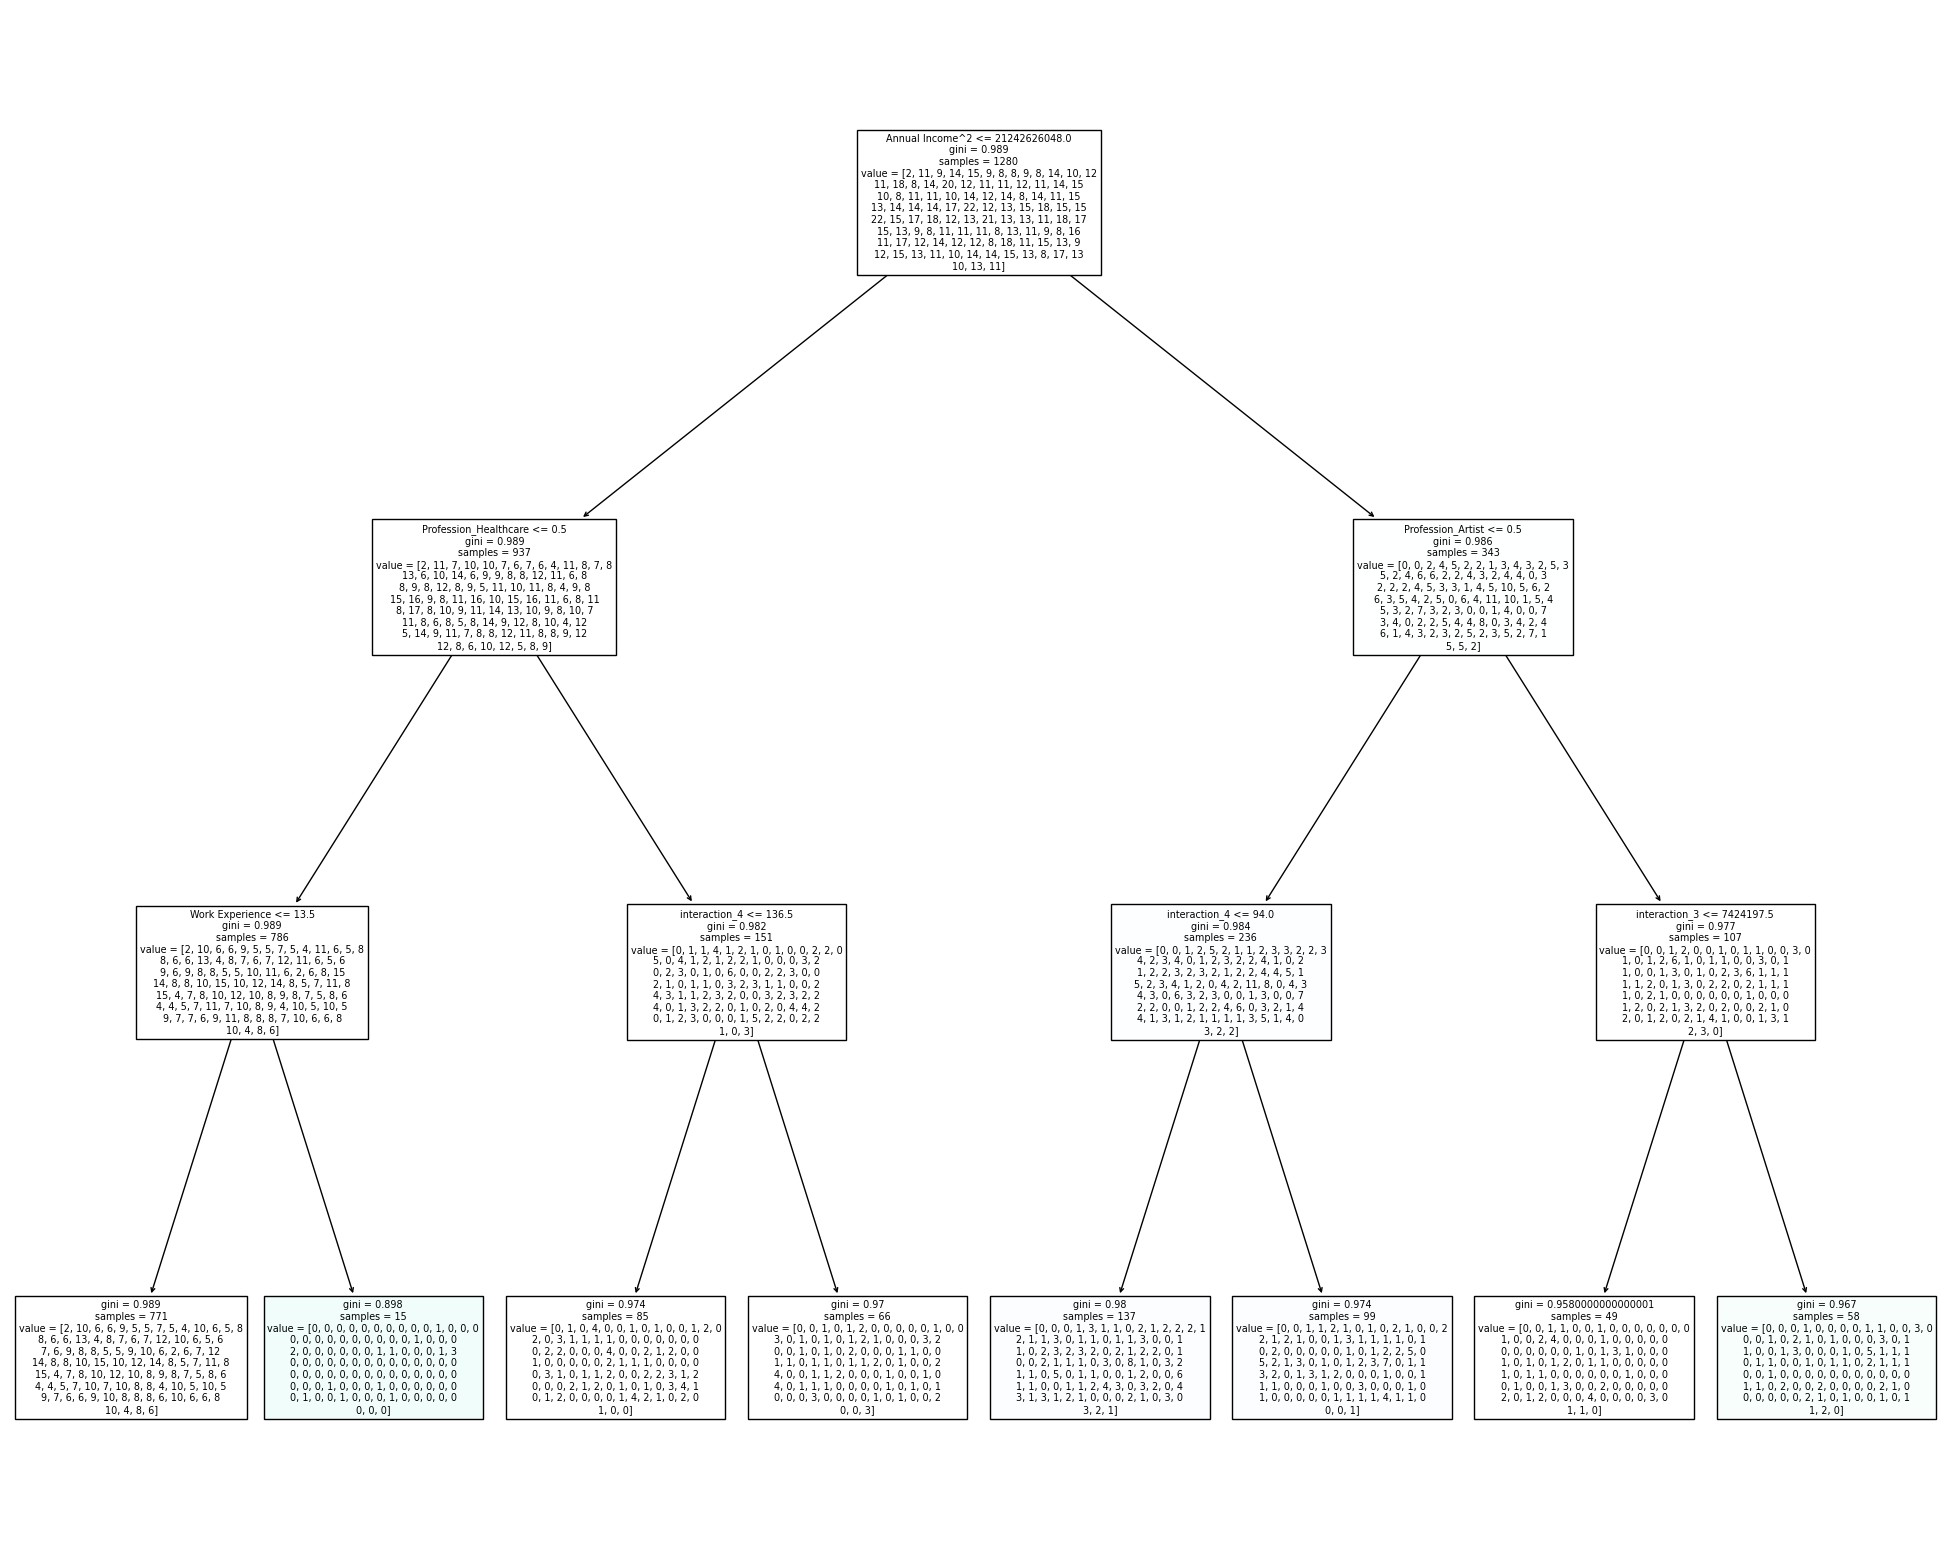

In [151]:
#variable 
# Defining the input and target variables
x= train.drop(columns= 'Spending Score (1-100)', axis=1)
y= train['Spending Score (1-100)']

#Splitting the data
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= .2, stratify=y)

#building decison tree
tree_md= DecisionTreeClassifier(max_depth= 3).fit(x_train, y_train)
fig=plt.figure(figsize= (25,20))
plot_tree(tree_md, feature_names= x_train.columns, filled=True)

In [152]:
#variables 7 and 8
#engineering features from the decisoon tree model
train['interaction_6']=np.where(((train['interaction_3'] <= 17141355) &
                                   (train['interaction_5'] <= 1016846.5) &
                                    (train['Annual Income^2'] <= 24427815936)), 1, 0)
                                 
train['interaction_7']=np.where(((train['Annual Income ($)'] <= 189472) &
                                   (train['interaction_5'] <= 1016846.5) &
                                (train['Annual Income ($)'] <= 187714)), 1, 0)
        
#engineering features from the decisoon tree model
test['interaction_6']=np.where(((test['interaction_3'] <= 17141355) &
                                   (test['interaction_5'] <= 1016846.5) &
                                    (test['Annual Income^2'] <= 24427815936)), 1, 0)
                                 
test['interaction_7']=np.where(((test['Annual Income ($)'] <= 189472) &
                                   (test['interaction_5'] <= 1016846.5) &
                                (test['Annual Income ($)'] <= 187714)), 1, 0)

In [ ]:
rf= list()

for i in range(0,100):
    
    #Defining input and target variables
    x= train.drop(columns='Spending Score (1-100)', axis=1)
    y= train['Spending Score (1-100)']

    #Splitting the data
    x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= .2, stratify=y)
    
    #running RFECV with Random forest model
    rf_rfecv = RFECV(estimator = RandomForestRegressor(n_estimators = 500, max_depth = 3), step= 1, min_features_to_select= 2, cv= 5).fit(x_train, y_train)
    #appending rankings
    rf.append(rf_rfecv.support_)
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Random Forest keeping the train and bringing in the test from the begining

In [22]:
rf= pd.DataFrame(rf)
rf.columns=x_train.columns
100*rf.apply(np.sum, axis=0)/rf.shape[0]

Age                         64.0
Annual Income ($)           82.0
Work Experience             26.0
Family Size                 30.0
Gender_Female               18.0
Gender_Male                 25.0
Profession_Artist           24.0
Profession_Doctor           22.0
Profession_Engineer         21.0
Profession_Entertainment    21.0
Profession_Executive        19.0
Profession_Healthcare       15.0
Profession_Homemaker        22.0
Profession_Lawyer           17.0
Profession_Marketing        15.0
interaction_3               98.0
interaction_4               54.0
interaction_5               57.0
Annual Income^2             74.0
interaction_6                5.0
interaction_7                5.0
dtype: float64

In [162]:
#defining input and target variables
x_train1= train[['Annual Income^2', 'Annual Income ($)', 'interaction_5', 'interaction_3', 'Age']]
x_test1= test[['Annual Income^2', 'Annual Income ($)', 'interaction_5', 'interaction_3', 'Age']]

In [163]:
#defining input and target variables
x_train2= train[['Annual Income^2', 'Annual Income ($)', 'interaction_3', 'interaction_5', 'Age', 'interaction_4']]
x_test2= test[['Annual Income^2', 'Annual Income ($)', 'interaction_3', 'interaction_5', 'Age', 'interaction_4']]

In [155]:
#building a random forest with best parameters
rf= RandomForestRegressor(n_estimators=500 , max_depth=3, min_samples_leaf= 5, min_samples_split= 10).fit(x_train1, train['Spending Score (1-100)'])

#predicting on the test
rf_pred= rf.predict(x_test1)

#changing likelyhoods to labels
rf_label= mean_squared_error(test['Spending Score (1-100)'], rf_pred)
rmse = np.sqrt(rf_label)

print('RMSE of model 1:', rmse)

RMSE of model 1: 28.19649036716296


In [156]:
#building a random forest with best parameters
rf= RandomForestRegressor(n_estimators=500 , max_depth=3, min_samples_leaf= 5, min_samples_split= 10).fit(x_train2, train['Spending Score (1-100)'])

#predicting on the test
rf_pred= rf.predict(x_test2)

#changing likelyhoods to labels
rf_label= mean_squared_error(test['Spending Score (1-100)'], rf_pred)
rmse = np.sqrt(rf_label)

print('RMSE of model 1:', rmse)

RMSE of model 1: 28.279204926578803


Randomm Forest Splitting the Train Data Frame

In [157]:
x= train.drop(columns='Spending Score (1-100)', axis=1)
y= train['Spending Score (1-100)']

#Splitting the data
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= .2, stratify= y)

In [158]:
#defining input and target variables
x_train3= x_train[['Annual Income^2', 'Annual Income ($)', 'interaction_3', 'interaction_5', 'Age']]
x_test3= x_test[['Annual Income^2', 'Annual Income ($)', 'interaction_3', 'interaction_5', 'Age']]

In [159]:
#defining input and target variables
x_train4= x_train[['Annual Income^2', 'Annual Income ($)', 'interaction_3', 'interaction_5', 'Age', 'interaction_4']]
x_test4= x_test[['Annual Income^2', 'Annual Income ($)', 'interaction_3', 'interaction_5', 'Age', 'interaction_4']]

In [160]:
#building a random forest with best parameters
rf= RandomForestRegressor(n_estimators=500 , max_depth=3, min_samples_leaf= 5, min_samples_split= 10).fit(x_train3, y_train)

#predicting on the test
rf_pred= rf.predict(x_test3)

#changing likelyhoods to labels
rf_label= mean_squared_error(y_test, rf_pred)
rmse = np.sqrt(rf_label)

print('RMSE of model 2:', rmse)

RMSE of model 2: 27.511459672487053


In [161]:
#building a random forest with best parameters
rf= RandomForestRegressor(n_estimators=500 , max_depth=3, min_samples_leaf= 5, min_samples_split= 10).fit(x_train4, y_train)

#predicting on the test
rf_pred= rf.predict(x_test4)

#changing likelyhoods to labels
rf_label= mean_squared_error(y_test, rf_pred)
rmse = np.sqrt(rf_label)

print('RMSE of model 2:', rmse)

RMSE of model 2: 27.6309259484265


In [ ]:
#I was a little confused on the directions so I tried it two ways: 
    #1. Using the original train to predict on the test data frame
    #2. Splitting the train like we usually do into x_train, x_test, y_train, y_test
#Both variable implementations in each technique were so similar that I don't know if it's worth adding in an extra variable to make your model more complex.
#Therefore, to predict on Spending score between 1-100, I would feel more comfortable choosing a model after running iterations. If you look above, models 3 and 4 had almost the same RMSE
#so it's hard to really see which one performs better in the long run.
#Note: if the idea was to do it the first way, I would still need to run iterations because the RMSE are way to close to decide
#The best idea for either technique is to run iterstions and average out the RMSE and then decide!